In [71]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import confusion_matrix
import os
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [27]:
current_path = os.path.join(os.getcwd(), '..')
base_path = f'{current_path}/data/raw/cats_and_dogs_filtered'
train_path = os.path.join(f'{base_path}/train/')
validation_path = os.path.join(f'{base_path}/validation/')

In [28]:
# (train / validation)
dogs_dataset = (os.path.join(train_path, 'dogs'),
                os.path.join(validation_path, 'dogs'))
cats_dataset = (os.path.join(train_path, 'cats'),
                os.path.join(validation_path, 'cats'))

IMG_HEIGHT = 299
IMG_WIDTH = 299

In [29]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 299, 299, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 149, 149, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 87616)            

In [30]:
batch_size = 128
epochs = 50

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_path,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_path,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [73]:
total_train = len(os.listdir(dogs_dataset[0])) + len(os.listdir(cats_dataset[0]))
total_val = len(os.listdir(dogs_dataset[1])) + len(os.listdir(cats_dataset[1]))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


history = model.fit_generator(
    train_data_gen,
    callbacks=[callback],
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15 steps, validate for 7 steps
Epoch 1/50
15/15 [==============================] - 93s 6s/step - loss: 3.0053 - accuracy: 0.4989 - val_loss: 0.6903 - val_accuracy: 0.5022
Epoch 2/50
15/15 [==============================] - 99s 7s/step - loss: 0.6797 - accuracy: 0.5304 - val_loss: 0.6689 - val_accuracy: 0.5123
Epoch 3/50
15/15 [==============================] - 97s 6s/step - loss: 0.6430 - accuracy: 0.5764 - val_loss: 0.6650 - val_accuracy: 0.6585
Epoch 4/50
15/15 [==============================] - 97s 6s/step - loss: 0.5736 - accuracy: 0.6928 - val_loss: 0.5973 - val_accuracy: 0.6350
Epoch 5/50
15/15 [==============================] - 117s 8s/step - loss: 0.4767 - accuracy: 0.7489 - val_loss: 0.6008 - val_accuracy: 0.6350
Epoch 6/50
15/15 [==============================] - 94s 6s/step - loss: 0.4229 - accuracy: 0.7874 - val_loss: 0.6156 - val_accuracy: 0.7076
Epoch 7/50
15/15 [==============================] - 115s 8s/step - l

In [43]:
def fix_X_array(raw_data):
    return np.concatenate(raw_data).reshape((raw_data.shape[0], IMG_HEIGHT, IMG_WIDTH, 3))

def fix_Y_array(raw_data):
    ravel = np.ravel(raw_data.iloc[:,1:].to_numpy())
    y_labels = []
    for y in ravel:
        y_labels.append(1 if y == 'dog' else 0)
    return np.array(y_labels)


def extract_features(img_dir, label):
    img = cv2.imread(img_dir)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    return [preprocess_input(img), label]

def extract_data(dataset, label):
    features = []
    for img_path in tqdm(os.listdir(dataset)):
        img_dir = os.path.join(dataset, img_path)
        features.append(extract_features(img_dir, label))
    return features

val_dataset = pd.concat([pd.DataFrame(x) for x in [
    extract_data(dogs_dataset[1], 'dog'),
    extract_data(cats_dataset[1], 'cat')
]])

X_val = fix_X_array((val_dataset.iloc[:,0]).to_numpy())
y_val = tf.keras.utils.to_categorical(fix_Y_array(val_dataset))


100%|██████████| 500/500 [00:01<00:00, 368.95it/s]


In [74]:
all_classes = ['cat', 'dog']

predictions = model.predict(X_val)

In [18]:
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

In [75]:
predictions
y_pred = predictions > 0
y_val_fixed = np.argmax(y_val, axis=1)


y_pred = y_pred.astype(int)
y_pred = y_pred.reshape(1, y_pred.shape[0])[0]

y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,

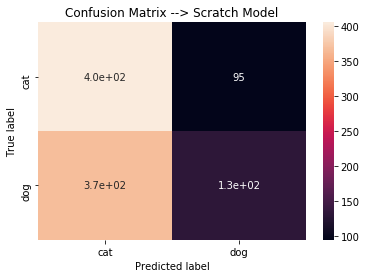

In [77]:
cm = confusion_matrix(y_val_fixed, y_pred)
df_cm = pd.DataFrame(cm, index=[all_classes], columns=all_classes)
sns.heatmap(df_cm, annot=True)
plt.title(f'Confusion Matrix --> Scratch Model')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()